In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

from arch import arch_model

from sklearn.model_selection import TimeSeriesSplit,GridSearchCV
from scikeras.wrappers import KerasRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score

from tensorflow.keras.regularizers import L2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, LSTM, Dense

## Data Processing

In [2]:
sp500_prices = yf.download("^GSPC", start='2018-01-05', end='2023-07-01')['Adj Close'].rename('sp500_price')
implied_vol = yf.download("^VIX", start='2018-02-01', end='2023-07-01')['Adj Close'].rename('implied_vol')
treasury_yield = yf.download("^IRX", start='2018-02-06', end='2023-07-01')['Adj Close'].rename('treasury')
volume = yf.download("^GSPC", start='2018-02-06', end='2023-07-01')['Volume'].rename('sp500_vol')

merged_data = pd.DataFrame(sp500_prices).join([implied_vol, treasury_yield, volume], how='outer')

Sentiment_Index = pd.read_csv("Sentiment_Index.csv", index_col=0)
Sentiment_Index.index = pd.to_datetime(Sentiment_Index.index, dayfirst=True)
merged_data = merged_data.join(Sentiment_Index, how='outer')

merged_data.to_csv('files/data.csv')

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [3]:
merged_data = pd.read_csv('files/data.csv')

In [4]:
merged_data.implied_vol = merged_data.implied_vol / (100 * np.sqrt(252))
merged_data['returns'] = merged_data.sp500_price/merged_data.sp500_price.shift(1) - 1

merged_data['realized_volatility'] = merged_data.returns.rolling(window=21).std()

merged_data['target'] = merged_data.implied_vol.shift(-1)
merged_data['implied_vol_lag_1'] = merged_data.implied_vol.shift(1)
merged_data['implied_vol_lag_2'] = merged_data.implied_vol.shift(2)

merged_data = merged_data[21:-1]

In [5]:
# Splitting into 60:20:20 train:validate:test sets
n= len(merged_data)

train = merged_data[:round(0.6*n)]
validate = merged_data[round(0.6*n):round(0.8*n)]
test = merged_data[round(0.8*n):]

## GARCH

In [6]:
# Fitting a GARCH(1,1) model
garch_model = arch_model(train['returns'], vol='Garch', p=1, q=1)
garch_results = garch_model.fit()

print(garch_results.summary())

Iteration:      1,   Func. Count:      6,   Neg. LLF: 85292073677.67297
Iteration:      2,   Func. Count:     19,   Neg. LLF: 30122116.535324637
Iteration:      3,   Func. Count:     31,   Neg. LLF: 16632.6932224298
Optimization terminated successfully    (Exit mode 0)
            Current function value: -2609.007627560215
            Iterations: 4
            Function evaluations: 38
            Gradient evaluations: 3
                     Constant Mean - GARCH Model Results                      
Dep. Variable:                returns   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                2609.01
Distribution:                  Normal   AIC:                          -5210.02
Method:            Maximum Likelihood   BIC:                          -5191.20
                                        No. Observations:                  815
Date:                Tu

/Users/anthony.li/Documents/GitHub/Neural-Network-Approach-to-Implied-Volatility-Forecasting/.venv/lib/python3.11/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0002051. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


In [7]:
parameters = garch_results.params
train['garch_forecast'] = garch_results.conditional_volatility.values
last_volatility = garch_results.conditional_volatility.values[-1]
validate['garch_forecast'] = None

# Obtaining the Garch Forecasted Volatility for Validation data
for i in range(len(validate)):
    forecasted_volatility = np.sqrt(parameters['omega'] +
                                    parameters['alpha[1]'] * validate['returns'].iloc[i]**2 +
                                    parameters['beta[1]'] * last_volatility**2)

    validate['garch_forecast'].iloc[i] = forecasted_volatility
    last_volatility = forecasted_volatility

# Calculating OOS-RMSE
GARCH_MSE = np.mean((validate.target - validate.garch_forecast) ** 2)
GARCH_RMSE = np.sqrt(GARCH_MSE)
print("The Root Mean Squared Error for the GARCH model is: ", GARCH_RMSE)

/var/folders/kh/_8wngh1d14l0cp2_xfplc2_w0000gr/T/ipykernel_54284/2068899185.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['garch_forecast'] = garch_results.conditional_volatility.values
/var/folders/kh/_8wngh1d14l0cp2_xfplc2_w0000gr/T/ipykernel_54284/2068899185.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validate['garch_forecast'] = None
/var/folders/kh/_8wngh1d14l0cp2_xfplc2_w0000gr/T/ipykernel_54284/2068899185.py:12: FutureWarning: ChainedAssignmentError: behaviour will change in panda

The Root Mean Squared Error for the GARCH model is:  0.003925963590286438


/var/folders/kh/_8wngh1d14l0cp2_xfplc2_w0000gr/T/ipykernel_54284/2068899185.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validate['garch_forecast'].iloc[i] = forecasted_volatility
/var/folders/kh/_8wngh1d14l0cp2_xfplc2_w0000gr/T/ipykernel_54284/2068899185.py:12: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer,

In [8]:
r_squared = r2_score(validate.garch_forecast, validate.target )

# Calculating adjusted R-squared
n = len(validate.garch_forecast)
p = 1
adjusted_r_squared = 1 - (1 - r_squared) * (n - 1) / (n - p - 1)

print('The OOS R-squared is: ', r_squared)
print('The OOS Adjusted R-squared is: ',adjusted_r_squared)

The OOS R-squared is:  0.13739332738492505
The OOS Adjusted R-squared is:  0.13418661112985042


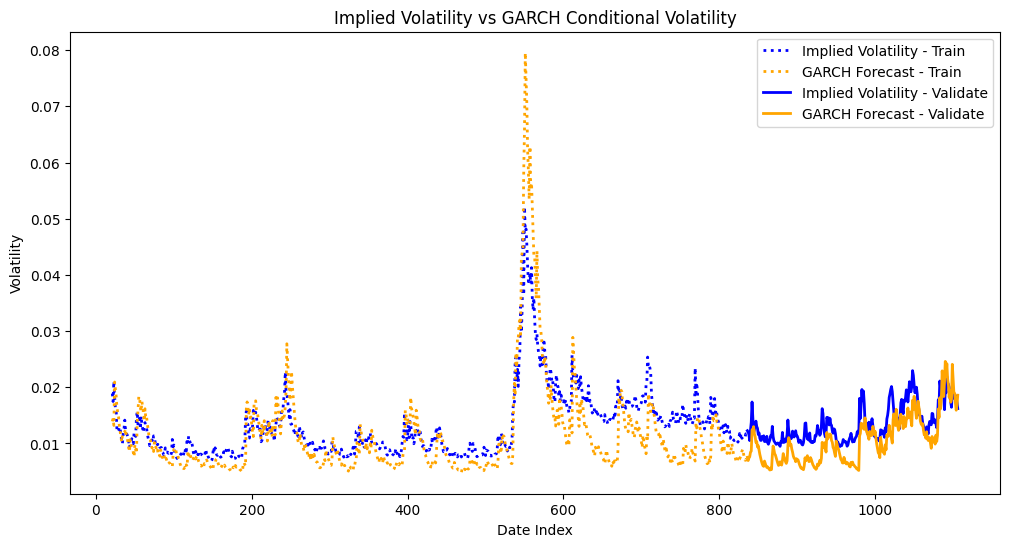

In [9]:
plt.figure(figsize=(12, 6))
plt.plot(train.index, train.implied_vol, label='Implied Volatility - Train', color='blue', linestyle=':', linewidth=2)
plt.plot(train.index, train.garch_forecast, label='GARCH Forecast - Train', color='orange', linestyle=':', linewidth=2)
plt.plot(validate.index, validate.implied_vol, label='Implied Volatility - Validate', color='blue', linestyle='-', linewidth=2)
plt.plot(validate.index, validate.garch_forecast, label='GARCH Forecast - Validate', color='orange', linestyle='-', linewidth=2)

plt.xlabel('Date Index')
plt.ylabel('Volatility')
plt.title('Implied Volatility vs GARCH Conditional Volatility')
plt.legend()
plt.show()

In [10]:
last_volatility = validate.garch_forecast.values[-1]
test['garch_forecast'] = None

# Obtaining the Garch Forecasted Volatility for Validation data
for i in range(len(test)):
    forecasted_volatility = np.sqrt(parameters['omega'] +
                                    parameters['alpha[1]'] * test['returns'].iloc[i]**2 +
                                    parameters['beta[1]'] * last_volatility**2)

    test['garch_forecast'].iloc[i] = forecasted_volatility
    last_volatility = forecasted_volatility

/var/folders/kh/_8wngh1d14l0cp2_xfplc2_w0000gr/T/ipykernel_54284/484451870.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['garch_forecast'] = None
/var/folders/kh/_8wngh1d14l0cp2_xfplc2_w0000gr/T/ipykernel_54284/484451870.py:10: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value


## LSTM

In [11]:
input_variables = ['implied_vol', 'treasury', 'sp500_vol',
                   'Sentiment_Index', 'returns', 'realized_volatility',
                   'implied_vol_lag_1', 'implied_vol_lag_2']

In [12]:
# Scaling input tensors using Min-Max scaler
scaler = MinMaxScaler()
train[input_variables] = scaler.fit_transform(train[input_variables])
validate[input_variables] = scaler.fit_transform(validate[input_variables])
test[input_variables] = scaler.fit_transform(test[input_variables])

/var/folders/kh/_8wngh1d14l0cp2_xfplc2_w0000gr/T/ipykernel_54284/1464570711.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train[input_variables] = scaler.fit_transform(train[input_variables])
/var/folders/kh/_8wngh1d14l0cp2_xfplc2_w0000gr/T/ipykernel_54284/1464570711.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validate[input_variables] = scaler.fit_transform(validate[input_variables])
/var/folders/kh/_8wngh1d14l0cp2_xfplc2_w0000gr/T/ipykernel_54284/1464570711.py:5: SettingWithCopyWarning: 
A v

#### Rolling Window K-Fold CV for Hyperparameter cross validation

In [ ]:
input_data = train[input_variables].values.reshape(train.shape[0], -1, len(input_variables))
target_data = train['target'].values

def create_model(lstm_1, lstm_2, dense):
    model = Sequential()
    model.add(Input(shape=(input_data.shape[1], input_data.shape[2])))  # Using Input layer
    model.add(LSTM(lstm_1, return_sequences=True))
    model.add(LSTM(lstm_2))
    model.add(Dense(dense, activation='linear'))
    model.add(Dense(1, activation='linear'))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model


# Defining the grid search of parameters
param_grid = {
    'model__lstm_1': [32, 64, 128, 256],
    'model__lstm_2': [32, 64, 128, 256],
    'model__dense': [16, 32, 64, 128]
}

# Creating a TimeSeriesSplit for cross-validation
tscv = TimeSeriesSplit(n_splits=5)
model = KerasRegressor(model=create_model, epochs=10, batch_size=32, verbose=0)

# Perform grid search with cross-validation
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=tscv)
grid_result = grid.fit(input_data, target_data)

# Print the best parameters and corresponding accuracy
print("The Best parameters: ", grid_result.best_params_)

In [ ]:
best_model = grid_result.best_estimator_.model_

validate_input = validate[input_variables].values.reshape(validate.shape[0], -1, len(input_variables))
validate_output = validate['target'].values


# Calculating OOS RMSE
NN_predictions = best_model.predict(validate_input)

NN_mse = np.mean((validate_output - NN_predictions.flatten()) ** 2)
NN_rmse = np.sqrt(NN_mse)
print("The Root Mean Squared Error for the Neural Network model is: ", NN_rmse)

In [ ]:
NN_r_squared = r2_score(NN_predictions, validate_output)

n = len(validate_output)
p = 8
NN_adjusted_r_squared = 1 - (1 - NN_r_squared) * (n - 1) / (n - p - 1)

print('The OOS R-squared is: ', NN_r_squared)
print('The OOS Adjusted R-squared is: ', NN_adjusted_r_squared)

In [ ]:
# Plotting actual IV against NN forecasted IV for test set
plt.figure(figsize=(12, 6))
plt.plot(validate.index,validate_output, label='Implied Volatility')
plt.plot(validate.index,NN_predictions, label='NN Forecast')
plt.xlabel('Date Index')
plt.ylabel('Implied Volatility')
plt.title('Actual vs Predicted values')
plt.legend()
plt.show()

In [ ]:
# Extracting the optimal hyperparameters
LSTM1 = grid_result.best_params_['model__lstm_1']
LSTM2 = grid_result.best_params_['model__lstm_2']
DENSE = grid_result.best_params_['model__dense']

# Defining NN model with the addition of L2 Regularization
model_REG = Sequential([
    LSTM(LSTM1, input_shape=(input_data.shape[1], input_data.shape[2]), return_sequences=True, kernel_regularizer= L2(0.001)),
    LSTM(LSTM2),
    Dense(DENSE, activation = 'linear'),
    Dense(1, activation = 'linear')
])

# Compiling the model
model_REG.compile(optimizer='adam', loss='mean_squared_error')

# Training the model on the Training dataset
history_REG = model_REG.fit(input_data, target_data, epochs=10, batch_size=64, validation_data=(validate_input, validate_output))

# Predicting the OOS Implied Volatility using NN model
NN_REG_predictions = model_REG.predict(validate_input)

# Calculating OOS RMSE
NN_REG_mse = np.mean((validate_output - NN_REG_predictions.flatten()) ** 2)
NN_REG_rmse = np.sqrt(NN_REG_mse)
print("The Root Mean Squared Error for the Neural Network model is: ", NN_REG_rmse)


In [ ]:
NN_r_squared = r2_score(validate_output, NN_REG_predictions)

n = len(validate_output)
p = 8
NN_adjusted_r_squared = 1 - (1 - NN_r_squared) * (n - 1) / (n - p - 1)

print('The OOS R-squared is: ', NN_r_squared)
print('The OOS Adjusted R-squared is: ', NN_adjusted_r_squared)

In [ ]:
# Plot the true IV against the NN forecasted IV for test data
plt.figure(figsize=(12, 6))
plt.plot(validate.index,validate_output, label='Implied Volatility')
plt.plot(validate.index,NN_REG_predictions, label='NN Forecast')
plt.xlabel('Date Index')
plt.ylabel('Implied Volatility')
plt.title('Actual vs Predicted values')
plt.legend()
plt.show()

## Unseen Test Data: GARCH vs LSTM with hyperparameter optimisation vs LSTM with hyperparameter optimisation and regularization

In [ ]:
test_input = test[input_variables].values.reshape(test.shape[0], -1, len(input_variables))
test_output = test['target'].values


# Calculating OOS RMSE
NN_test_predictions = best_model.predict(test_input)
NN_REG_test_predictions = model_REG.predict(test_input)

In [ ]:
# Plot the true IV against the NN forecasted IV for test data
plt.figure(figsize=(12, 6))
plt.plot(test.index,test_output, label='Implied Volatility')
plt.plot(test.index,NN_test_predictions, label='NN Forecast')
plt.plot(test.index,NN_REG_test_predictions, label='NN with Regularization Forecast')
plt.plot(test.index,test.garch_forecast, label='GARCH')
plt.xlabel('Date Index')
plt.ylabel('Implied Volatility')
plt.title('Actual vs Predicted values')
plt.legend()
plt.show()

## Improvements
Since time and length of the report was a constraint, I was unable to look at other variables and architectures that could lead to better forecasts. Further analysis could be done on validating the model by looking at the ICE and PDP plots.

Additionally, a rolling window training period would likely perform better as it will take in the latest available information which will better tune the parameters. However, this would be computationally expensive as Neural Networks are complex architectures with exponentially large number of computations.

Given the recent research in gradient boosting, I believe a gradient boosted regression model could potentially outperform all models discussed in this project.